In [1]:
#from keras_facenet import FaceNet
from scipy import misc
#from mtcnn.mtcnn import MTCNN
import mxnet as mx

In [2]:
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import skimage
from sklearn.utils import shuffle
import pandas as pd
import sklearn
import os
import math

import time
from imutils import face_utils

In [3]:
from AIengine import *
ai_engine = AIengine('./models')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:820: UserWarning: inception_resnet_v1 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
W0529 12:19:02.447772 140197865969472 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


./models/model.pkl
Loading AI Engine


In [4]:
from align_dlib import *

In [5]:
dlib_model = AlignDlibFast('./models/shape_predictor_5_face_landmarks.dat')

In [6]:
net = cv2.dnn.readNetFromCaffe('./cv2/deploy.prototxt.txt', './cv2/res10_300x300_ssd_iter_140000.caffemodel')

In [13]:
def random_rotate_image(image):
    angle = np.random.uniform(low=-10.0, high=10.0)
    return skimage.transform.rotate(image, angle, 'bicubic')

def rotate_image(image, angle = 0):
    return skimage.transform.rotate(image, angle, 'bicubic')

def preprocess(images, margin=10, image_size=160, model_path='./cv2/haarcascade_frontalface_alt2.xml', face_extract_algo=face_extract_dnn):
        try:
            #t = time.time()
            faceDetected = True
            aligned_images = []
            for img in images:
                # print(filepath)
                if type(img) is list:
                    img = np.array(img)
                img = to_rgb(img)
                #print("Time till init...")
                #print(time.time() - t)
                aligned = dlib_model.align(img)#align_face(img)
                if aligned is None:
                    #print(type(aligned))
                    #plt.imshow(img)
                    #plt.show()
                    #continue
                    aligned = img
                #print("Time till dlib align...")
                #print(time.time() - t)
                _img, faceDetected = face_extract_dnn(aligned, margin, image_size = image_size)#face_extract_dnn(img, margin)
                #print("Time till face extract...")
                #print(time.time() - t)
                if faceDetected is False:
                    print("No face detected")
                    print(type(aligned))
                    plt.imshow(img)
                    plt.show()
                    continue
                aligned_images.append(_img)
            if len(aligned_images) == 0:
                return images, False
            #print(time.time() - t)
            return np.array(aligned_images), faceDetected
        except Exception as e:
            print("Error in Preprocess ")
            print(e)
            return images, False

In [5]:

def align_and_crop_face(image, desiredLeftEye=(0.35, 0.35), desiredFaceWidth = 160, desiredFaceHeight = 160):
    t = time.time()
    detection = mtcnn_model.detect_faces(img)[0]
    confidence = detection['confidence']
    if confidence <= 0.4:
        print("No face found!")
        return None
    (x1, y1) = detection['keypoints']['left_eye']
    (x2, y2) = detection['keypoints']['right_eye']
    (x, y, p, q) = detection['box']
    dX = float(x2 - x1)
    dY = float(y2 - y1)
    angle = (math.atan(dY/dX)*180)/math.pi
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= desiredFaceWidth
    scale = desiredDist / dist
    rotationCenter = ((x1 + x2) // 2, (y1 + y2) // 2)
    M = cv2.getRotationMatrix2D(rotationCenter, angle, scale)
    tX = desiredFaceWidth * 0.5
    tY = desiredFaceHeight * desiredLeftEye[1]
    M[0, 2] += (tX - rotationCenter[0])
    M[1, 2] += (tY - rotationCenter[1])
    # apply the affine transformation
    (w, h) = (desiredFaceWidth, desiredFaceHeight)
    output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    #print(time.time()-t)
    return output

def align_face(image):
    t = time.time()
    try:
        detection = mtcnn_model.detect_faces(image)[0]
        confidence = detection['confidence']
        if confidence <= 0.4:
            print("No face found!")
            return image, False
        (x1, y1) = detection['keypoints']['left_eye']
        (x2, y2) = detection['keypoints']['right_eye']
        (x, y, p, q) = detection['box']
        dX = float(x2 - x1)
        dY = float(y2 - y1)
        angle = (math.atan(dY/dX)*180)/math.pi
        return (rotate_image(image, angle)*255).astype('uint8'), True
    except Exception as e:
        print("Alignment failed")
        print(e)
        return image, False

def rotate_image_scalfree(img, angle):
    rotationCenter = img.shape[0]/2, img.shape[1]/2
    M = cv2.getRotationMatrix2D(rotationCenter, angle, 1)
    tX = 160 * 0.5
    tY = 160 * 0.5#desiredLeftEye[1]
    M[0, 2] += (tX - rotationCenter[0])
    M[1, 2] += (tY - rotationCenter[1])
    # apply the affine transformation
    (w, h) = (160, 160)
    output = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
    return output
    

In [7]:
# TESTING
cv2.destroyAllWindows()
import dlib
INNER_EYES_AND_BOTTOM_LIP = [3, 1, 4]

In [5]:
def embed(images, preprocess=False):
        try:
            #t = time.time()
            status = True
            if preprocess is True:
                images, status = preprocess(images, 10)
            emb = l2_normalize(coreModel.predict(images))
            return np.array(emb), status
        except Exception as e:
            print("Error in AIengine.embed")
            print(e)
        return None, False

In [6]:
notDetected = list()
def loadRawOrderedData(dir_basepath, margin=10, augment_size = 0):
    names = os.listdir(dir_basepath)
    imgs = []
    labels = []
    nameDict = dict()
    for i in names:
        nameDict[hash(i)] = i
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)]
        for i in filepaths:
            _img = imread(i)
            imgs_, status = preprocess([_img], margin) 
            if status is False:
                #imgs_, status = AIengine.preprocess([imread(i)], cascade_path = './cv2/lbpcascade_profileface.xml') 
                if status is False:
                    print("No face detected in " + i)
                    notDetected.append(imgs_)
                    continue
                else: 
                    print("Detected hard image " + i)
            imgs.append(imgs_)
            labels.append(name)
            for j in range(0, augment_size):
                tmp = random_rotate_image(_img)
                im, status = preprocess([tmp], margin) 
                if status is not False:
                    imgs.append(im)
                    labels.append(name)
                else:
                    notDetected.append(im)
                    print("No face detected")
            # Augmented Data
        #labels.extend([name] * len(imgs_))
        #imgs.append(imgs_)
    imgs = np.concatenate(imgs)
    return imgs, labels, nameDict


def loadRawTestData(filepaths):
    imgs = [np.array(imread(i)) for i in filepaths]
    return np.array(imgs)

In [7]:
def loadRawYalesData(filepath):
    imgs = [np.array(imread(filepath + i)) for i in os.listdir(filepath)] 
    return np.array(imgs)

In [8]:
cascade_path = './cv2/haarcascade_frontalface_alt2.xml'
image_dir_basepath = './images/'

train_dirpath = os.path.join(image_dir_basepath, 'Train/')

image_size = 160

In [9]:
# Load Raw Data
imgs, labels, nameDict = loadRawOrderedData(train_dirpath, augment_size=0)

In [10]:
imgs.shape

(329, 160, 160, 3)

In [14]:
metadata = {'labelEncodeMap': {value: key for key,
                                       value in nameDict.items()}, 'labelDecodeMap': nameDict,
                         'imagesize': 160, 'similarity_margin': 10}
import pickle
f = open('./models/Customs/model_facenet_cnn_align_stranger.meta', 'wb')
f.write(pickle.dumps(metadata))
f.close()

In [67]:
# Get Embeddings from the Data
embs, status = embed(imgs, preprocess = False)
embs = np.array(embs)
X = [embs, imgs]
Y = np.array([hash(i) for i in labels])
#X, test_x, Y, test_y = train_test_split(X,Y,test_size=0.00000001)
#X, Y = shuffle(X, Y)

In [106]:
integer_encoded

array([-2969918865790314929, -2969918865790314929, -2969918865790314929,
       -2969918865790314929,  1138967923488258215,  1138967923488258215,
        1138967923488258215,  1138967923488258215, -1943265901480066458,
       -1943265901480066458, -1943265901480066458, -1943265901480066458,
       -1943265901480066458,  5144605892742913773,  5144605892742913773,
       -4301631673254350430, -4301631673254350430, -4301631673254350430,
       -4301631673254350430, -4301631673254350430, -4301631673254350430,
       -3675462507704240419, -3675462507704240419, -3675462507704240419,
       -3675462507704240419, -3675462507704240419, -3675462507704240419,
       -3675462507704240419, -3675462507704240419, -3675462507704240419,
         270713385978887918,   270713385978887918,   270713385978887918,
         270713385978887918,   270713385978887918,   270713385978887918,
         270713385978887918,   270713385978887918,   270713385978887918,
         270713385978887918, -2117923525357575966, 

In [108]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)
print(onehot_encoded.shape)

Y_encoded = onehot_encoded

(329, 27)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [19]:
# Create grouped object
vecDict = dict()
for i in labels:
    vecDict[i] = list()
for i in range(0, len(labels)):
    vecDict[labels[i]].append(embs[i])

In [20]:
# Save to JSON Document
import pickle
f = open('./models/Customs/vectormaps_facenet_cnn_align_stranger.json', 'wb')
f.write(pickle.dumps(vecDict))
f.close()

In [82]:
# Our Classifier
import tensorflow as tf
import tensorflow.keras

# Define two input layers
image_input = tf.keras.Input((160, 160, 3))
vector_input = tf.keras.Input((512,))

# CNN Network ->
# (INCEPTION Module)
#tower_1 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(image_input)
#tower_1 = tf.keras.layers.Conv2D(10, (3,3), padding='same', activation='relu')(tower_1)

#tower_2 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(image_input)
#tower_2 = tf.keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(tower_2)

#tower_3 = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(image_input)
#tower_3 = tf.keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(tower_3)
#output1 = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
#cnnout = tf.keras.layers.Flatten()(output1)

# CIFAR CNN->
cnn = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(image_input)
cnn = tf.keras.layers.Activation('relu')(cnn)
cnn = tf.keras.layers.Conv2D(32, (3, 3))(cnn)
cnn = tf.keras.layers.Activation('relu')(cnn)
cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = tf.keras.layers.Dropout(0.25)(cnn)

cnn = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(cnn)
cnn = tf.keras.layers.Activation('relu')(cnn)
cnn = tf.keras.layers.Conv2D(64, (3, 3))(cnn)
cnn = tf.keras.layers.Activation('relu')(cnn)
cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = tf.keras.layers.Dropout(0.25)(cnn)

cnn = tf.keras.layers.Flatten()(cnn)
cnnout = tf.keras.layers.Dense(10, activation="softmax")(cnn)

# Fully connected ->
x = tf.keras.layers.concatenate([cnnout, vector_input])
x = tf.keras.layers.Dense(50, activation='relu')(x)
output = tf.keras.layers.Dense(Y_encoded.shape[-1], activation='softmax')(x)

model = tf.keras.models.Model(inputs=[vector_input, image_input], outputs=output)
model.compile(optimizer = 'rmsprop', loss='logcosh', metrics=['accuracy', 'mae'])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 160, 160, 32) 896         input_49[0][0]                   
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 160, 160, 32) 0           conv2d_92[0][0]                  
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 158, 158, 16) 4624        activation_22[0][0]              
___________________________________________________________________________________________

In [85]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_names = os.listdir(test_dirpath)
test_filepaths = [os.path.join(test_dirpath, f) for f in test_names]
test_labels = [i.split('.')[0] for i in test_names]
test_imgs = loadRawTestData(test_filepaths)
len(test_labels)

53

In [87]:
test_pre, status = preprocess(test_imgs)
test_vec, status = embed(test_pre, preprocess=False)
#print(test_vec)
test_pre.shape

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [95]:
test_Y = onehot_encoder.transform(label_encoder.transform([hash(i) for i in test_labels]).reshape(len(test_labels), 1))

In [96]:
#classifier.fit(X, Y)
model.fit(X, Y_encoded,batch_size=1,epochs=20, validation_data=([test_vec, test_pre], test_Y),shuffle=True)

Train on 329 samples, validate on 53 samples
Epoch 1/20
329/329 [==============================] - 4s 13ms/sample - loss: 1.4748e-05 - accuracy: 1.0000 - mae: 5.5894e-04 - val_loss: 8.6902e-04 - val_accuracy: 0.9434 - val_mae: 0.0041
Epoch 2/20
329/329 [==============================] - 4s 11ms/sample - loss: 5.7732e-06 - accuracy: 1.0000 - mae: 4.0356e-04 - val_loss: 7.5880e-04 - val_accuracy: 0.9623 - val_mae: 0.0036
Epoch 3/20
329/329 [==============================] - 4s 11ms/sample - loss: 2.1985e-06 - accuracy: 1.0000 - mae: 2.9088e-04 - val_loss: 5.3294e-04 - val_accuracy: 0.9623 - val_mae: 0.0030
Epoch 4/20
329/329 [==============================] - 4s 11ms/sample - loss: 1.1108e-06 - accuracy: 1.0000 - mae: 2.2838e-04 - val_loss: 5.6232e-04 - val_accuracy: 0.9623 - val_mae: 0.0030
Epoch 5/20
329/329 [==============================] - 4s 11ms/sample - loss: 4.6230e-07 - accuracy: 1.0000 - mae: 1.7523e-04 - val_loss: 5.2459e-04 - val_accuracy: 0.9623 - val_mae: 0.0029
Epoch 6/20

In [114]:
pred = model.predict([test_vec, test_pre])#infer(classifier, test_filepaths)
predictions = list()
for i in pred:
    predictions.append(label_encoder.inverse_transform([np.argmax(i)])[0])
predictions = np.array(predictions)
results = [(nameDict[i],j) for i,j in zip(predictions,test_labels)]
#print(results)
pred_labels = [i[0] for i in results]
for i in results:
    print(i)

('Davinder', 'Davinder')
('Abhishek', 'Abhishek')
('Nikhil', 'Nikhil')
('Nikhil', 'Nikhil')
('Ashish', 'Ashish')
('Neha', 'Neha')
('Santosh', 'Santosh')
('Santosh', 'Santosh')
('Abhishek', 'Abhishek')
('Suresh', 'Suresh')
('Davinder', 'Davinder')
('Santosh', 'Santosh')
('LarryPage', 'LarryPage')
('AnthonyHopkins', 'AnthonyHopkins')
('Sonali', 'Sonali')
('Davinder', 'Davinder')
('CPSingh', 'CPSingh')
('Surya', 'Surya')
('Dushyant', 'Dushyant')
('Harendra', 'Harendra')
('Davinder', 'Davinder')
('Davinder', 'Davinder')
('Maneet', 'CPSingh')
('Stranger', 'Stranger')
('Harendra', 'Harendra')
('Stranger', 'Stranger')
('Stranger', 'Stranger')
('Nikhil', 'Nikhil')
('Stranger', 'Stranger')
('Dushyant', 'Dushyant')
('Santosh', 'Santosh')
('Stranger', 'MarkZuckerberg')
('Ashish', 'Ashish')
('Nagesh', 'Nagesh')
('Aayushi', 'Aayushi')
('Pankaj', 'Pankaj')
('CPSingh', 'CPSingh')
('Jyoti', 'Jyoti')
('BillGates', 'BillGates')
('Nagesh', 'Nagesh')
('Dushyant', 'Dushyant')
('Ashish', 'Ashish')
('Santosh

In [115]:
for i in results:
    if i[0] != i[1]:
        print("FOUND")
        print(i)

FOUND
('Maneet', 'CPSingh')
FOUND
('Stranger', 'MarkZuckerberg')


[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


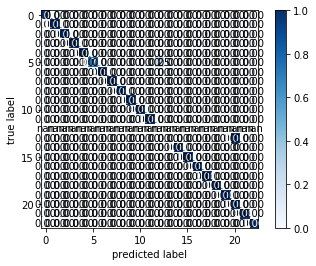

In [116]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [117]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

0.9622641509433962

In [318]:
# Save the model
f = open('./models/Customs/model_facenet_align_mlp_stranger.pkl', 'wb')
f.write(pickle.dumps(classifier))
f.close()

In [319]:
# Check the effectiveness of Similarity matching
# We use yale dataset as a source of 'stranger' photos. Lets see what happens
 
yales_imgs = loadRawYalesData('./images/validate/')
yales_pre, status = preprocess(yales_imgs)
yales_labels = ['Stranger'] * len(yales_pre)
yales_embs, status = embed(yales_pre, preprocess=False)

In [320]:
print(yales_embs.shape)
print(test_vec.shape)
print(len(yales_labels))

(166, 512)
(53, 512)
166


In [321]:
val_embs = np.concatenate([yales_embs, test_vec])
val_labels = np.concatenate([yales_labels, test_labels])
pred_labels = list()
for i in val_embs:
    name = nameDict[classifier.predict([i])[0]]
    uvecs = vecDict[name]
    if name != 'Stranger':
        print(name)
        val = validateSimilarity(uvecs, i)
        if val is True:
            pred_labels.append(name)
        else:
            print("Person " + name + " Not Verified")
            pred_labels.append('Stranger')
    else:
        pred_labels.append('Stranger')
        
results = [(i,j) for i,j in zip(pred_labels,val_labels)]

Davinder
Similar to 5 Photos of the person out of 5
Abhishek
Similar to 9 Photos of the person out of 9
Nikhil
Similar to 10 Photos of the person out of 10
Nikhil
Similar to 10 Photos of the person out of 10
Ashish
Similar to 10 Photos of the person out of 10
Neha
Similar to 11 Photos of the person out of 11
Santosh
Similar to 12 Photos of the person out of 12
Santosh
Similar to 12 Photos of the person out of 12
Abhishek
Similar to 9 Photos of the person out of 9
Suresh
Similar to 4 Photos of the person out of 4
Davinder
Similar to 5 Photos of the person out of 5
Santosh
Similar to 12 Photos of the person out of 12
LarryPage
Similar to 3 Photos of the person out of 3
AnthonyHopkins
Similar to 2 Photos of the person out of 2
Sonali
Similar to 10 Photos of the person out of 10
Davinder
Similar to 5 Photos of the person out of 5
CPSingh
Similar to 19 Photos of the person out of 19
Surya
Similar to 10 Photos of the person out of 10
Dushyant
Similar to 11 Photos of the person out of 11
Hare

In [322]:
print(pred_labels)

['Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'St

FOUND
('Stranger', 'CPSingh')
[[  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0]
 [  0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   

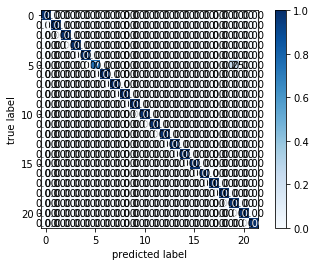

In [323]:
for i in results:
    if i[0] != i[1]:
        print("FOUND")
        print(i)
        
cm = sklearn.metrics.confusion_matrix(val_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [87]:
results

[('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 

In [144]:
print(test_labels[6], pred_labels[6])

LarryPage Stranger


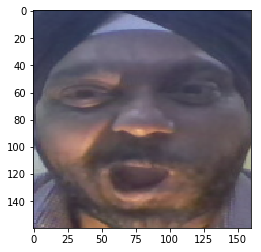

In [83]:
plt.imshow(test_pre[14])

In [38]:
test_labels[:5]

['Abhishek', 'Nikhil', 'Ashish', 'Santosh', 'Abhishek']

In [39]:
json.loads(a.text)

NameError: name 'json' is not defined

In [16]:
import requests as re
import json
import pickle

In [29]:
train_x, test_x, train_y, test_y = train_test_split(imgs,labels,test_size=0)

In [47]:
train_y[10:20]

['Harendra',
 'Neha',
 'Suresh',
 'Jyoti',
 'Harvinder',
 'Nikhil',
 'AnthonyHopkins',
 'Jyoti',
 'Sonali',
 'Harendra']

In [39]:
test_labels

['Abhishek',
 'Nikhil',
 'Ashish',
 'Santosh',
 'Abhishek',
 'Suresh',
 'LarryPage',
 'AnthonyHopkins',
 'Davinder',
 'Sonu',
 'Surya',
 'Harendra',
 'Davinder',
 'CPSingh',
 'Dushyant',
 'MarkZuckerberg',
 'Aayushi',
 'Pankaj',
 'Jyoti',
 'BillGates',
 'Nagesh',
 'Neha',
 'Sonali',
 'Harvinder']

In [42]:
pred_labels

['Abhishek',
 'Neha',
 'Surya',
 'Santosh',
 'Abhishek',
 'Suresh',
 'BillGates',
 'AnthonyHopkins',
 'Davinder',
 'Suresh',
 'Surya',
 'Neha',
 'BillGates',
 'Surya',
 'Dushyant',
 'BillGates',
 'Neha',
 'Santosh',
 'Neha',
 'Dushyant',
 'Abhishek',
 'Neha',
 'Neha',
 'Neha']

In [52]:
c = [i for i,j in zip(pred_labels, test_labels) if i == j]
print(c)
print(len(c))
print(len(c)/len(pred_labels))

['Nikhil', 'Suresh', 'AnthonyHopkins', 'Harendra', 'Jyoti', 'Neha', 'Sonali', 'Harvinder']
8
0.3333333333333333


In [97]:
test_imgs[0].dtype == 'float'

False

In [36]:
preprocess([i for i in test_imgs])

array([[[[0.87120481, 0.87120481, 0.87120481],
         [0.87131204, 0.87131204, 0.87131204],
         [0.87463235, 0.87463235, 0.87463235],
         ...,
         [0.99203431, 0.99203431, 0.99203431],
         [0.99239047, 0.99239047, 0.99239047],
         [0.99571461, 0.99571461, 0.99571461]],

        [[0.8884689 , 0.8884689 , 0.8884689 ],
         [0.89157858, 0.89157858, 0.89157858],
         [0.89522059, 0.89522059, 0.89522059],
         ...,
         [0.98860294, 0.98860294, 0.98860294],
         [0.98863741, 0.98863741, 0.98863741],
         [0.9889591 , 0.9889591 , 0.9889591 ]],

        [[0.89693627, 0.89693627, 0.89693627],
         [0.90036765, 0.90036765, 0.90036765],
         [0.90404412, 0.90404412, 0.90404412],
         ...,
         [0.99433594, 0.99433594, 0.99433594],
         [0.99185432, 0.99185432, 0.99185432],
         [0.99474954, 0.99474954, 0.99474954]],

        ...,

        [[0.08212699, 0.08212699, 0.08212699],
         [0.0758004 , 0.0758004 , 0.0758004 ]

In [17]:
# Create Model
t = re.post("http://localhost:5000/create", data=json.dumps({'user':'ashish'}))

In [128]:
a = re.post("http://localhost:5000/classify", data=json.dumps({'preprocess':True, 'data':[i.tolist() for i in test_imgs], 'user':'ashish', 'type':'img'}))
#[i.tolist() for i in test_imgs[:5]]
#test_imgs.tolist()
pred_labels = json.loads(a.text)

In [53]:
t = re.post("http://localhost:5000/train", data=json.dumps({'preprocess':False, 'data':train_x.tolist(), 'user':'ashish', 'type':'img', 'labels':train_y}))

In [26]:
g = np.array(imgs[:2].tolist())
g.shape

(2, 160, 160, 3)

In [23]:
t = re.post("http://localhost:5000/similarity", data=json.dumps({'img':imgs[1].tolist(), 'data':imgs[7].tolist(), 'user':'help', 'type':'img'}))

In [35]:
a.shape

(12, 512)

In [32]:
a.text

'["AnthonyHopkins"]\n'

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0

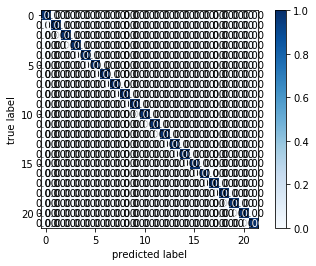

In [126]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [56]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

1.0

In [41]:
del model

In [49]:
import sys
from __future__ import print_function  # for Python2
l = list()
for var, obj in locals().items():
    l.append([sys.getsizeof(var), var])
l = sorted(l)
for i in l:
    print(i)

print(sum((lambda i:[j[0] for j in i])(l)))

[50, '_']
[51, 'In']
[51, '__']
[51, '_i']
[51, 'ax']
[51, 'cm']
[51, 'np']
[51, 'os']
[51, 'pd']
[51, 're']
[51, 'tf']
[52, 'Out']
[52, 'PCA']
[52, 'SVC']
[52, '_14']
[52, '_17']
[52, '_21']
[52, '_22']
[52, '_27']
[52, '_28']
[52, '_36']
[52, '_37']
[52, '_38']
[52, '___']
[52, '_dh']
[52, '_i1']
[52, '_i2']
[52, '_i3']
[52, '_i4']
[52, '_i5']
[52, '_i6']
[52, '_i7']
[52, '_i8']
[52, '_i9']
[52, '_ih']
[52, '_ii']
[52, '_oh']
[52, '_sh']
[52, 'auc']
[52, 'cv2']
[52, 'fig']
[52, 'obj']
[52, 'plt']
[52, 'sys']
[52, 'var']
[53, '_i10']
[53, '_i11']
[53, '_i12']
[53, '_i13']
[53, '_i14']
[53, '_i15']
[53, '_i16']
[53, '_i17']
[53, '_i18']
[53, '_i19']
[53, '_i20']
[53, '_i21']
[53, '_i22']
[53, '_i23']
[53, '_i24']
[53, '_i25']
[53, '_i26']
[53, '_i27']
[53, '_i28']
[53, '_i29']
[53, '_i30']
[53, '_i31']
[53, '_i32']
[53, '_i33']
[53, '_i34']
[53, '_i35']
[53, '_i36']
[53, '_i37']
[53, '_i38']
[53, '_i39']
[53, '_i40']
[53, '_i41']
[53, '_i42']
[53, '_i43']
[53, '_i44']
[53, '_i45']
[53,

In [51]:
sys.getsizeof(imgs)

52224144

In [53]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                          imgs:  49.8MiB
                     test_imgs:  14.1MiB
                          embs: 170.1KiB
                             X: 170.1KiB
                           _28:  88.0KiB
                            cm:   3.9KiB
                           SVC:   2.0KiB
                             l:   1.9KiB
                          _i23:   1.3KiB
                           _i8:   1.3KiB


In [12]:
import cv2

In [11]:
camera = cv2.VideoCapture(0)

In [41]:
ret, frame = camera.read()

In [42]:
frame.shape

(480, 640, 3)

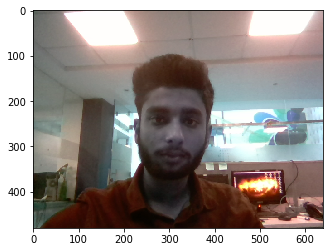

In [43]:
plt.imshow(frame)

In [58]:
n = prewhiten(aligned[0])


W0520 12:40:40.647694 140634822248256 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


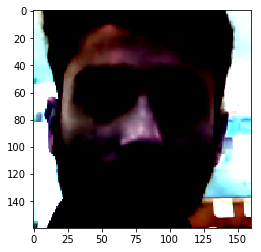

In [59]:
plt.imshow(n)

In [96]:
def align_images(images, margin = 70, image_size = 160):
        try:
            aligned_images = []
            cascade = cv2.CascadeClassifier(cascade_path)
            for img in images:
                #print(filepath)
                if type(img) is list:
                    img = np.array(img)
                img = to_rgb(img)
                try:
                    faces = cascade.detectMultiScale(img,
                                                    scaleFactor=1.1,
                                                    minNeighbors=3)
                    (x, y, w, h) = faces[0]
                    print(faces[0].dtype)
                    cropped = img[y-margin//2:y+h+margin//2,
                                x-margin//2:x+w+margin//2, :]
                    print(cropped.dtype)
                except Exception as e:
                    print("error in face detection")
                    print(e)
                    cropped = img
                img = resize(cropped, (image_size, image_size), mode='reflect')
                #if img.dtype in ('uint8', 'int64'):
                    #img = img.astype('float')/255.
                print(cropped)
                print(img)
                
                #plt.imshow(img)
                #plt.show()
                #img = resize(img, (image_size, image_size), mode='reflect')
                #plt.imshow(img)
                #plt.show()
                aligned_images.append(img)
                return np.array(aligned_images)
        except Exception as e:
            print("Error in Preprocess ")
            print(e)
            return None

In [97]:
aligned = align_images([frame], 50)

int32
uint8
[[[167 150 141]
  [168 151 142]
  [169 152 143]
  ...
  [157 157 157]
  [157 157 157]
  [157 157 157]]

 [[165 149 143]
  [165 149 143]
  [166 150 144]
  ...
  [158 157 160]
  [157 156 159]
  [157 156 159]]

 [[165 149 143]
  [166 150 144]
  [166 150 144]
  ...
  [157 159 161]
  [156 158 160]
  [156 158 160]]

 ...

 [[ 92  60  45]
  [ 90  59  44]
  [ 88  57  42]
  ...
  [ 87  65  48]
  [ 87  69  54]
  [ 88  70  55]]

 [[ 90  57  40]
  [ 90  57  40]
  [ 86  53  35]
  ...
  [ 88  64  47]
  [ 87  67  52]
  [ 90  70  55]]

 [[ 84  50  30]
  [ 84  50  29]
  [ 82  48  26]
  ...
  [ 88  64  47]
  [ 87  67  52]
  [ 89  69  54]]]
[[[0.6507037  0.5850787  0.55474782]
  [0.65364871 0.58802371 0.55769282]
  [0.65386029 0.59017023 0.55824621]
  ...
  [0.61568627 0.61280637 0.61871458]
  [0.61464461 0.61176471 0.61672794]
  [0.61464461 0.61176471 0.61672794]]

 [[0.64393382 0.58118873 0.55686275]
  [0.64705882 0.58431373 0.55998775]
  [0.64785539 0.58613568 0.56207108]
  ...
  [0.615686

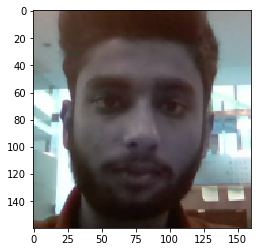

In [89]:
plt.imshow(aligned[0])

In [65]:
del camera